<a href="https://colab.research.google.com/github/ykkimhgu/DLIP-src/blob/main/Tutorial_PyTorch_MNIST_MLP_Part1_Train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **DLIP Tutorial - PyTorch**

## MNIST Classification using PyTorch 
Y.-K. Kim
(created 2021. 5. 3) 
(updated 2022. 2. 15) 



The purpose of this tutorial is to learn how to build a simple Multi-Layer Percentron (MLP or ANN) for classification of handwritting digits (MNIST)

===================

## Setup Pytorch and Numpy and GPU

In [54]:
import torch 
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
print(torch.__version__)
import numpy as np 

1.10.0+cu111


In [5]:
# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cpu device


## Prepare Datasets
### OpenDataset from TorchVision


1. Loading OpenDataset (Fashion MNIST) from Pytorch data
* ``Dataset``:  stores the samples and their corresponding labels
* ``DataLoader`` wraps an iterable around the ``Dataset``.


In [3]:
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor


In [ ]:
# Download training data from open datasets.
training_data = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),   #converts 0~255 value to 0~1 value.
)

# Download test data from open datasets.
test_data = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

2. Use  ``DataLoader`` to  make dataset iterable.
* supports automatic batching, sampling, shuffling and multiprocess data loading. 



In [7]:
batch_size = 64

# Create data loaders.
train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

for X, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of X [N, C, H, W]: torch.Size([64, 1, 28, 28])
Shape of y: torch.Size([64]) torch.int64


3. Plot some training data


In [ ]:
import matplotlib.pyplot as plt

dataiter = iter(train_dataloader)
images, labels = dataiter.next()

figure = plt.figure()
num_of_images = 9
for index in range(num_of_images):
    plt.subplot(3, 3, index+1)
    plt.axis('off')    
    plt.title("Ground Truth: {}".format(labels[index]))
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

# Define model

create a class that inherits from nn.Module


* Define the layers of the network in  __init__ function
* Specify Forward network in the **forward function.**

![](https://github.com/bentrevett/pytorch-image-classification/blob/master/assets/mlp-mnist.png?raw=1)


* Image Input: 1x28x28  image
* Flatten into a 1*784 element vector
* 1st Layer: linear to 250 dimensions / ReLU
* 2nd Layer: linear to 100 dim / ReLU
* 3rd Layer: linear to 10 dim / log SoftMax
* Output:  1x10 

Actication function: ReLU

**NOTE**


1) nn.Linear(InputDim, OutputDim)


2) x.view( )
* Similar to  NumPy Reshape(). /// [batch size, height * width]

In [57]:
# Define model
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.flatten = nn.Flatten()
        self.linear1 = nn.Linear(28*28, 250)
        self.linear2 = nn.Linear(250, 100)
        self.linear3 = nn.Linear(100, 10)

        
    def forward(self, x):
        x=self.flatten(x)
        x= F.relu(self.linear1(x))
        x = F.relu(self.linear2(x))
        y_pred = F.log_softmax(self.linear3(x))
        return y_pred


model = MLP().to(device)
print(model)

MLP(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear1): Linear(in_features=784, out_features=250, bias=True)
  (linear2): Linear(in_features=250, out_features=100, bias=True)
  (linear3): Linear(in_features=100, out_features=10, bias=True)
)


## Weight Initialization
 In Keras, dense layers by default uses “glorot_uniform” random initializer, it is also called Xavier normal initializer.

# Optimization Setup  

### Optmizer function 
 Gradient descent is the common optimisation strategy used in neural networks. Many of the variants and advanced optimisation functions now are available, 
  
- Stochastic Gradient Descent, Adagrade, Adam, etc

### Loss function

1. Linear regression->Mean Squared Error
2. Classification->Cross entropy, 

In [14]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

# Train the model
### Define train() function 
Reuse this function in other tutorials


In [12]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

### Train 
Print training process

In [ ]:
epochs = 2
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)    
print("Done!")

# Test the model  ``eval()`` 

### Define **test()** function 
Using ``eval()`` for test. Evaluate mode로 전환
This function can be reused in other tutorials

In [47]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            y_pred=pred.argmax(1);
            test_loss += loss_fn(pred, y).item()
            correct += (y_pred == y).type(torch.float).sum().item()
            
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")


(Option 2) Returning y_prediction 

In [55]:
def get_predictions(dataloader, model, loss_fn):
    images = []
    labels = []
    y_preds = []

    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            y_pred=pred.argmax(1);
            test_loss += loss_fn(pred, y).item()
            correct += (y_pred == y).type(torch.float).sum().item()

            # .cpu() GPU 메모리에서 cpu 메모리로 복사 및 Append
            images.append(X.cpu())    
            labels.append(y.cpu())
            y_preds.append(y_pred.cpu())
            
    images = torch.cat(images, dim=0)
    labels = torch.cat(labels, dim=0)
    y_preds = torch.cat(y_preds, dim=0)

    return images, labels, y_preds

### Test 
Print test data accuracy 

In [58]:
epochs = 2
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    test(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  from ipykernel import kernelapp as app


Test Error: 
 Accuracy: 10.0%, Avg loss: 2.300260 

Epoch 2
-------------------------------
Test Error: 
 Accuracy: 10.0%, Avg loss: 2.300260 

Done!


### Visualize test results

Select random test images and evaluate

In [39]:
# Get some random test  images // BatchSize at a time
dataiter = iter(test_dataloader)
images, labels = dataiter.next()
print(images.size())


# Evaluate mode로 전환
# Prediction of some sample images 
with torch.no_grad():
  for X, y in dataiter:
      X, y = X.to(device), y.to(device)
      pred = model(X)
      _, predicted = torch.max(pred.data, 1)


torch.Size([64, 1, 28, 28])


tensor([1, 2, 3, 4, 3, 6, 7, 3, 4, 0, 1, 2, 3, 9, 8, 6])

Plot some test image results

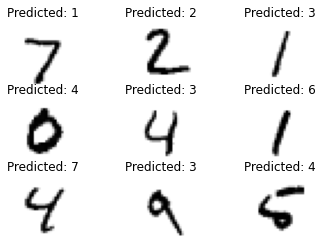

In [32]:
figure = plt.figure()
num_of_images = 9
for index in range(num_of_images):
    plt.subplot(3, 3, index+1)
    plt.axis('off')    
    plt.title("Predicted: {}".format(predicted[index].item()))
    plt.imshow(images[index].cpu().numpy().squeeze(), cmap='gray_r')

# Saving Models
(Option 1) Save Model with Shapes
* save the structure of this class together with the model

In [44]:
torch.save(model,"MNIST_model.pth")

Saved PyTorch Model State


(Option 2) Save Model Weight as  state dictionary 

In [ ]:
torch.save(model.state_dict(), "MNIST_model2.pth")
print("Saved PyTorch Model State")



---



# Exercise


## Exercise 1
Change , activation functions and optimization types for a better output.

## Exercise 2
Rewrite  the above MLP model as the following. 

![](https://raw.githubusercontent.com/dmlc/web-data/master/mxnet/image/mlp_mnist.png)

